# Head Pose Estimation using BIWI Dataset
Lightweight CNN-based regression model for estimating pitch, yaw, and roll angles.

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Dataset class for BIWI
class BIWIDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

In [7]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np

class BIWIHeadPoseDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = []
        self.pose_files = []
        
        for person_dir in sorted(os.listdir(root_dir)):
            person_path = os.path.join(root_dir, person_dir)
            if not os.path.isdir(person_path):
                continue
            for file in sorted(os.listdir(person_path)):
                if file.endswith('_rgb.jpg'):
                    frame_id = file.replace('_rgb.jpg', '')
                    img_path = os.path.join(person_path, file)
                    pose_path = os.path.join(person_path, frame_id + '_pose.txt')
                    if os.path.exists(pose_path):
                        self.image_files.append(img_path)
                        self.pose_files.append(pose_path)

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        pose_path = self.pose_files[idx]

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)

        # Load head pose
        with open(pose_path) as f:
            lines = f.readlines()
            rotation_matrix = np.array([[float(num) for num in line.strip().split()] for line in lines[:3]])
            pitch = np.arcsin(-rotation_matrix[2][0]) * 180 / np.pi
            yaw = np.arctan2(rotation_matrix[2][1], rotation_matrix[2][2]) * 180 / np.pi
            roll = np.arctan2(rotation_matrix[1][0], rotation_matrix[0][0]) * 180 / np.pi
            angles = torch.tensor([pitch, yaw, roll], dtype=torch.float32)

        return img, angles


In [8]:
from torch.utils.data import DataLoader

dataset = BIWIHeadPoseDataset(root_dir='D:/biwi_head_pose/biwi_head_pose')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example usage
images, labels = next(iter(dataloader))
print(images.shape, labels.shape)  # (32, 3, 224, 224) and (32, 3)


torch.Size([32, 3, 224, 224]) torch.Size([32, 3])


In [9]:
# # Example data loading (Replace with actual paths and angles)
# image_paths = ['path/to/image1.png', 'path/to/image2.png']
# labels = [[0.0, 0.0, 0.0], [10.0, 5.0, -3.0]]  # pitch, yaw, roll

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5]*3, [0.5]*3)
# ])

# dataset = BIWIDataset(image_paths, labels, transform=transform)
# train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [11]:
# Model definition
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 3)  # pitch, yaw, roll
model = model.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
import time as time
from datetime import timedelta
# Training loop
EPOCHS = 10
PATIENCE = 4
best_loss = float('inf')
patience_counter = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# For checkpointing
checkpoint_path = 'head_pose_checkpoint.pt'

# Load checkpoint if exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    best_loss = checkpoint['best_loss']
    print(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 0

def format_time(seconds):
    return str(timedelta(seconds=int(seconds)))

for epoch in range(start_epoch, EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_start_time = time.time()
    total_batches = len(dataloader)
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        _, target_labels = torch.max(targets, 1)
        correct += (predicted == target_labels).sum().item()
        total += targets.size(0)
        
        # Calculate progress and time estimates
        progress = (batch_idx + 1) / total_batches * 100
        elapsed_time = time.time() - epoch_start_time
        eta = (total_batches - (batch_idx + 1)) * (elapsed_time / (batch_idx + 1))
        
        # Print simplified progress
        print(f"\rEpoch [{epoch+1}/{EPOCHS}] | Progress: {progress:.1f}% | "
              f"Loss: {running_loss/(batch_idx+1):.4f} | "
              f"Accuracy: {100 * correct / total:.2f}% | "
              f"Time: {format_time(elapsed_time)} / ETA: {format_time(eta)}", 
              end="")
    
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print("\n" + "="*80)
    print(f"Epoch [{epoch+1}/{EPOCHS}] completed in {format_time(time.time() - epoch_start_time)}")
    print(f"Training   - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}% ({correct}/{total})")
    
    # Validation (if applicable)
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_start_time = time.time()
    
    with torch.no_grad():
        for inputs, targets in dataloader:  # Replace with validation dataloader if available
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            _, target_labels = torch.max(targets, 1)
            val_correct += (predicted == target_labels).sum().item()
            val_total += targets.size(0)
    
    val_loss /= len(dataloader)  # Replace with validation dataloader length if available
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}% ({val_correct}/{val_total})")
    print(f"Time: Total: {format_time(time.time() - epoch_start_time)}, "
          f"Train: {format_time(elapsed_time)}, Val: {format_time(time.time() - val_start_time)}")
    
    # Save checkpoint
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'best_loss': best_loss
    }, checkpoint_path)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'head_pose_best_model.pt')
        patience_counter = 0
        print("✓ Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break
    
    print("="*80)


Resuming from epoch 1
Epoch [2/10] | Progress: 100.0% | Loss: 28.9789 | Accuracy: 90.00% | Time: 0:05:49 / ETA: 0:00:00
Epoch [2/10] completed in 0:05:49
Training   - Loss: 28.9789, Accuracy: 90.00% (14110/15678)
Validation - Loss: 19.0271, Accuracy: 90.15% (14134/15678)
Time: Total: 0:06:59, Train: 0:05:49, Val: 0:01:10
✓ Saved new best model
Epoch [3/10] | Progress: 100.0% | Loss: 22.9712 | Accuracy: 90.76% | Time: 0:02:20 / ETA: 0:00:00
Epoch [3/10] completed in 0:02:20
Training   - Loss: 22.9712, Accuracy: 90.76% (14230/15678)
Validation - Loss: 15.2137, Accuracy: 91.25% (14306/15678)
Time: Total: 0:03:33, Train: 0:02:20, Val: 0:01:12
✓ Saved new best model
Epoch [4/10] | Progress: 100.0% | Loss: 17.8294 | Accuracy: 92.05% | Time: 0:02:24 / ETA: 0:00:00
Epoch [4/10] completed in 0:02:24
Training   - Loss: 17.8294, Accuracy: 92.05% (14432/15678)
Validation - Loss: 7.4399, Accuracy: 94.81% (14864/15678)
Time: Total: 0:03:38, Train: 0:02:24, Val: 0:01:13
✓ Saved new best model
Epoch [

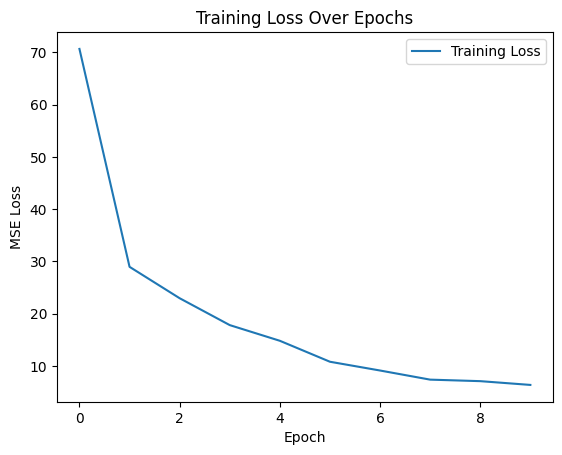

In [16]:
# Plot losses
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()